In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import holidays
import IPython
import keras_tuner as kt
import keras
import _pickle as pkl
import re

from pygments.lexer import combined
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import MSTL
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer

# Prep Work

In [90]:
def load_and_concat_data(file_paths: list, column_names: list) -> pd.DataFrame:
    """
    Load and concatenate data from multiple CSV files given by file_paths.

    :param file_paths: List of file paths to the CSV files.
    :param column_names: List of column names.

    :returns: pd.DataFrame: DataFrame for each feature containing raw data from the years 2023 - 2024.
    """
    df = []
    for file_path in file_paths:
        # Skip extra row for DK and FR prices because there is an extra disclaimer header row
        if re.search(r'fr_prices|dk_._prices', file_path):
            df.append(pd.read_csv(file_path, skiprows=3, names=column_names))
        else:
            df.append(pd.read_csv(file_path, header=1, names=column_names))
            
    concat_data = pd.concat(df)
    concat_data.reset_index(drop=True, inplace=True)
    concat_data['timestamp'] = pd.to_datetime(concat_data['timestamp'])
    concat_data.set_index('timestamp', inplace=True)
    
    # if na values are present interpolate them based on the timestamp
    if concat_data.isna().sum().sum() > 0:
        concat_data.interpolate(method='time', inplace=True)
    
    return concat_data

### File Paths and Column Names config

In [87]:
file_paths = {
    'de_prices': ['../data/raw/de_prices_2023.csv', '../data/raw/de_prices_2024.csv'],
    'de_load': ['../data/raw/de_load_2023.csv', '../data/raw/de_load_2024.csv'],
    'de_solar_gen': ['../data/raw/de_solar_gen_2023.csv', '../data/raw/de_solar_gen_2024.csv'],
    'de_wind_gen_offshore': ['../data/raw/de_wind_gen_offshore_2023.csv', '../data/raw/de_wind_gen_offshore_2024.csv'],
    'de_wind_gen_onshore': ['../data/raw/de_wind_gen_onshore_2023.csv', '../data/raw/de_wind_gen_onshore_2024.csv'],
    'de_gas_gen': ['../data/raw/de_gas_gen_2023.csv', '../data/raw/de_gas_gen_2024.csv'],
    'de_lignite_gen': ['../data/raw/de_lignite_gen_2023.csv', '../data/raw/de_lignite_gen_2024.csv'],
    'de_hard_coal_gen': ['../data/raw/de_hardcoal_gen_2023.csv', '../data/raw/de_hardcoal_gen_2024.csv'],
    'ch_load': ['../data/raw/ch_load_2023.csv', '../data/raw/ch_load_2024.csv'],
    'dk_load': ['../data/raw/dk_load_2023.csv', '../data/raw/dk_load_2024.csv'],
    'fr_load': ['../data/raw/fr_load_2023.csv', '../data/raw/fr_load_2024.csv'],
    'ch_prices': ['../data/raw/ch_prices_2023.csv', '../data/raw/ch_prices_2024.csv'],
    'dk1_prices': ['../data/raw/dk_1_prices_2023.csv', '../data/raw/dk_1_prices_2024.csv'],
    'dk2_prices': ['../data/raw/dk_2_prices_2023.csv', '../data/raw/dk_2_prices_2024.csv'],
    'fr_prices': ['../data/raw/fr_prices_2023.csv', '../data/raw/fr_prices_2024.csv'],
}

column_names = {
    'de_prices': ['timestamp', 'de_lu_price'],
    'de_load': ['timestamp', 'de_load'],
    'de_solar_gen': ['timestamp', 'de_solar_gen'],
    'de_wind_gen_offshore': ['timestamp', 'de_wind_gen_offshore'],
    'de_wind_gen_onshore': ['timestamp', 'de_wind_gen_onshore'],
    'de_gas_gen': ['timestamp', 'de_gas_gen'],
    'de_lignite_gen': ['timestamp', 'de_lignite_gen'],
    'de_hard_coal_gen': ['timestamp', 'de_hard_coal_gen'],
    'ch_load': ['timestamp', 'ch_load'],
    'dk_load': ['timestamp', 'dk_load'],
    'fr_load': ['timestamp', 'fr_load'],
    'ch_prices': ['timestamp', 'ch_prices'],
    'dk1_prices': ['timestamp', 'dk1_prices'],
    'dk2_prices': ['timestamp', 'dk2_prices'],
    'fr_prices': ['timestamp', 'fr_prices'],
}

### Populate new dataframes with raw data from years 2023 and 2024

In [91]:
de_prices = load_and_concat_data(file_paths['de_prices'], column_names['de_prices'])
de_load = load_and_concat_data(file_paths['de_load'], column_names['de_load'])
de_solar_gen = load_and_concat_data(file_paths['de_solar_gen'], column_names['de_solar_gen'])
de_wind_gen_offshore = load_and_concat_data(file_paths['de_wind_gen_offshore'], column_names['de_wind_gen_offshore'])
de_wind_gen_onshore = load_and_concat_data(file_paths['de_wind_gen_onshore'], column_names['de_wind_gen_onshore'])
de_gas_gen = load_and_concat_data(file_paths['de_gas_gen'], column_names['de_gas_gen'])
de_lignite_gen = load_and_concat_data(file_paths['de_lignite_gen'], column_names['de_lignite_gen'])
de_hard_coal_gen = load_and_concat_data(file_paths['de_hard_coal_gen'], column_names['de_hard_coal_gen'])
ch_load = load_and_concat_data(file_paths['ch_load'], column_names['ch_load'])
dk_load = load_and_concat_data(file_paths['dk_load'], column_names['dk_load'])
fr_load = load_and_concat_data(file_paths['fr_load'], column_names['fr_load'])
ch_prices = load_and_concat_data(file_paths['ch_prices'], column_names['ch_prices'])
dk1_prices = load_and_concat_data(file_paths['dk1_prices'], column_names['dk1_prices'])
dk2_prices = load_and_concat_data(file_paths['dk2_prices'], column_names['dk2_prices'])
fr_prices = load_and_concat_data(file_paths['fr_prices'], column_names['fr_prices'])

In [103]:
# sub-sampling the quarter hourly timeseries to hourly. see ../README.md for affected timeseries
de_load = de_load[::4]
de_solar_gen = de_solar_gen[::4]
de_wind_gen_offshore = de_wind_gen_offshore[::4]
de_wind_gen_onshore = de_wind_gen_onshore[::4]
de_gas_gen = de_gas_gen[::4]
de_lignite_gen = de_lignite_gen[::4]
de_hard_coal_gen = de_hard_coal_gen[::4]

In [104]:
dataframes = [
    de_prices,
    de_load,
    de_solar_gen,
    de_wind_gen_offshore,
    de_wind_gen_onshore,
    de_gas_gen,
    de_lignite_gen,
    de_hard_coal_gen,
    ch_load,
    dk_load,
    fr_load,
    ch_prices,
    dk1_prices,
    dk2_prices,
    fr_prices    
]

combined_df = pd.concat(dataframes, axis=1)

In [106]:
# save dataset to csv in ../data/interim
combined_df.to_csv('../data/interim/combined_data.csv', index=True)

# Statisical Analysis

In [95]:
# statistical overview
combined_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
de_lu_price,17544.0,87.364521,57.217911,-500.00,62.8675,88.850,112.5000,2325.83
de_load,70176.0,52660.885957,9146.020138,27932.90,45133.8000,52620.950,59759.2250,75766.70
de_solar_gen,70176.0,6775.300281,10467.557921,0.80,3.2000,111.500,10712.4500,47065.80
de_wind_gen_offshore,70176.0,2803.653534,1863.546252,0.00,1123.5750,2608.650,4331.3500,7640.30
de_wind_gen_onshore,70176.0,13186.427301,10299.038422,42.40,4916.8250,10353.250,19277.9000,48157.90
de_gas_gen,70176.0,6230.694668,3204.983150,1586.30,3681.8250,5572.150,7992.3000,19168.90
de_lignite_gen,70176.0,8483.260824,3538.360315,2461.60,5346.1250,8347.950,11190.3000,17200.80
de_hard_coal_gen,70176.0,3823.886427,2855.113169,307.40,1793.2000,2931.800,5123.2250,15256.20
ch_load,17544.0,6879.845651,1053.874647,2742.60,6185.0500,6898.400,7588.7250,10437.10
dk_load,17544.0,4061.867909,718.324942,2371.20,3526.4750,4047.250,4587.7250,9069.60


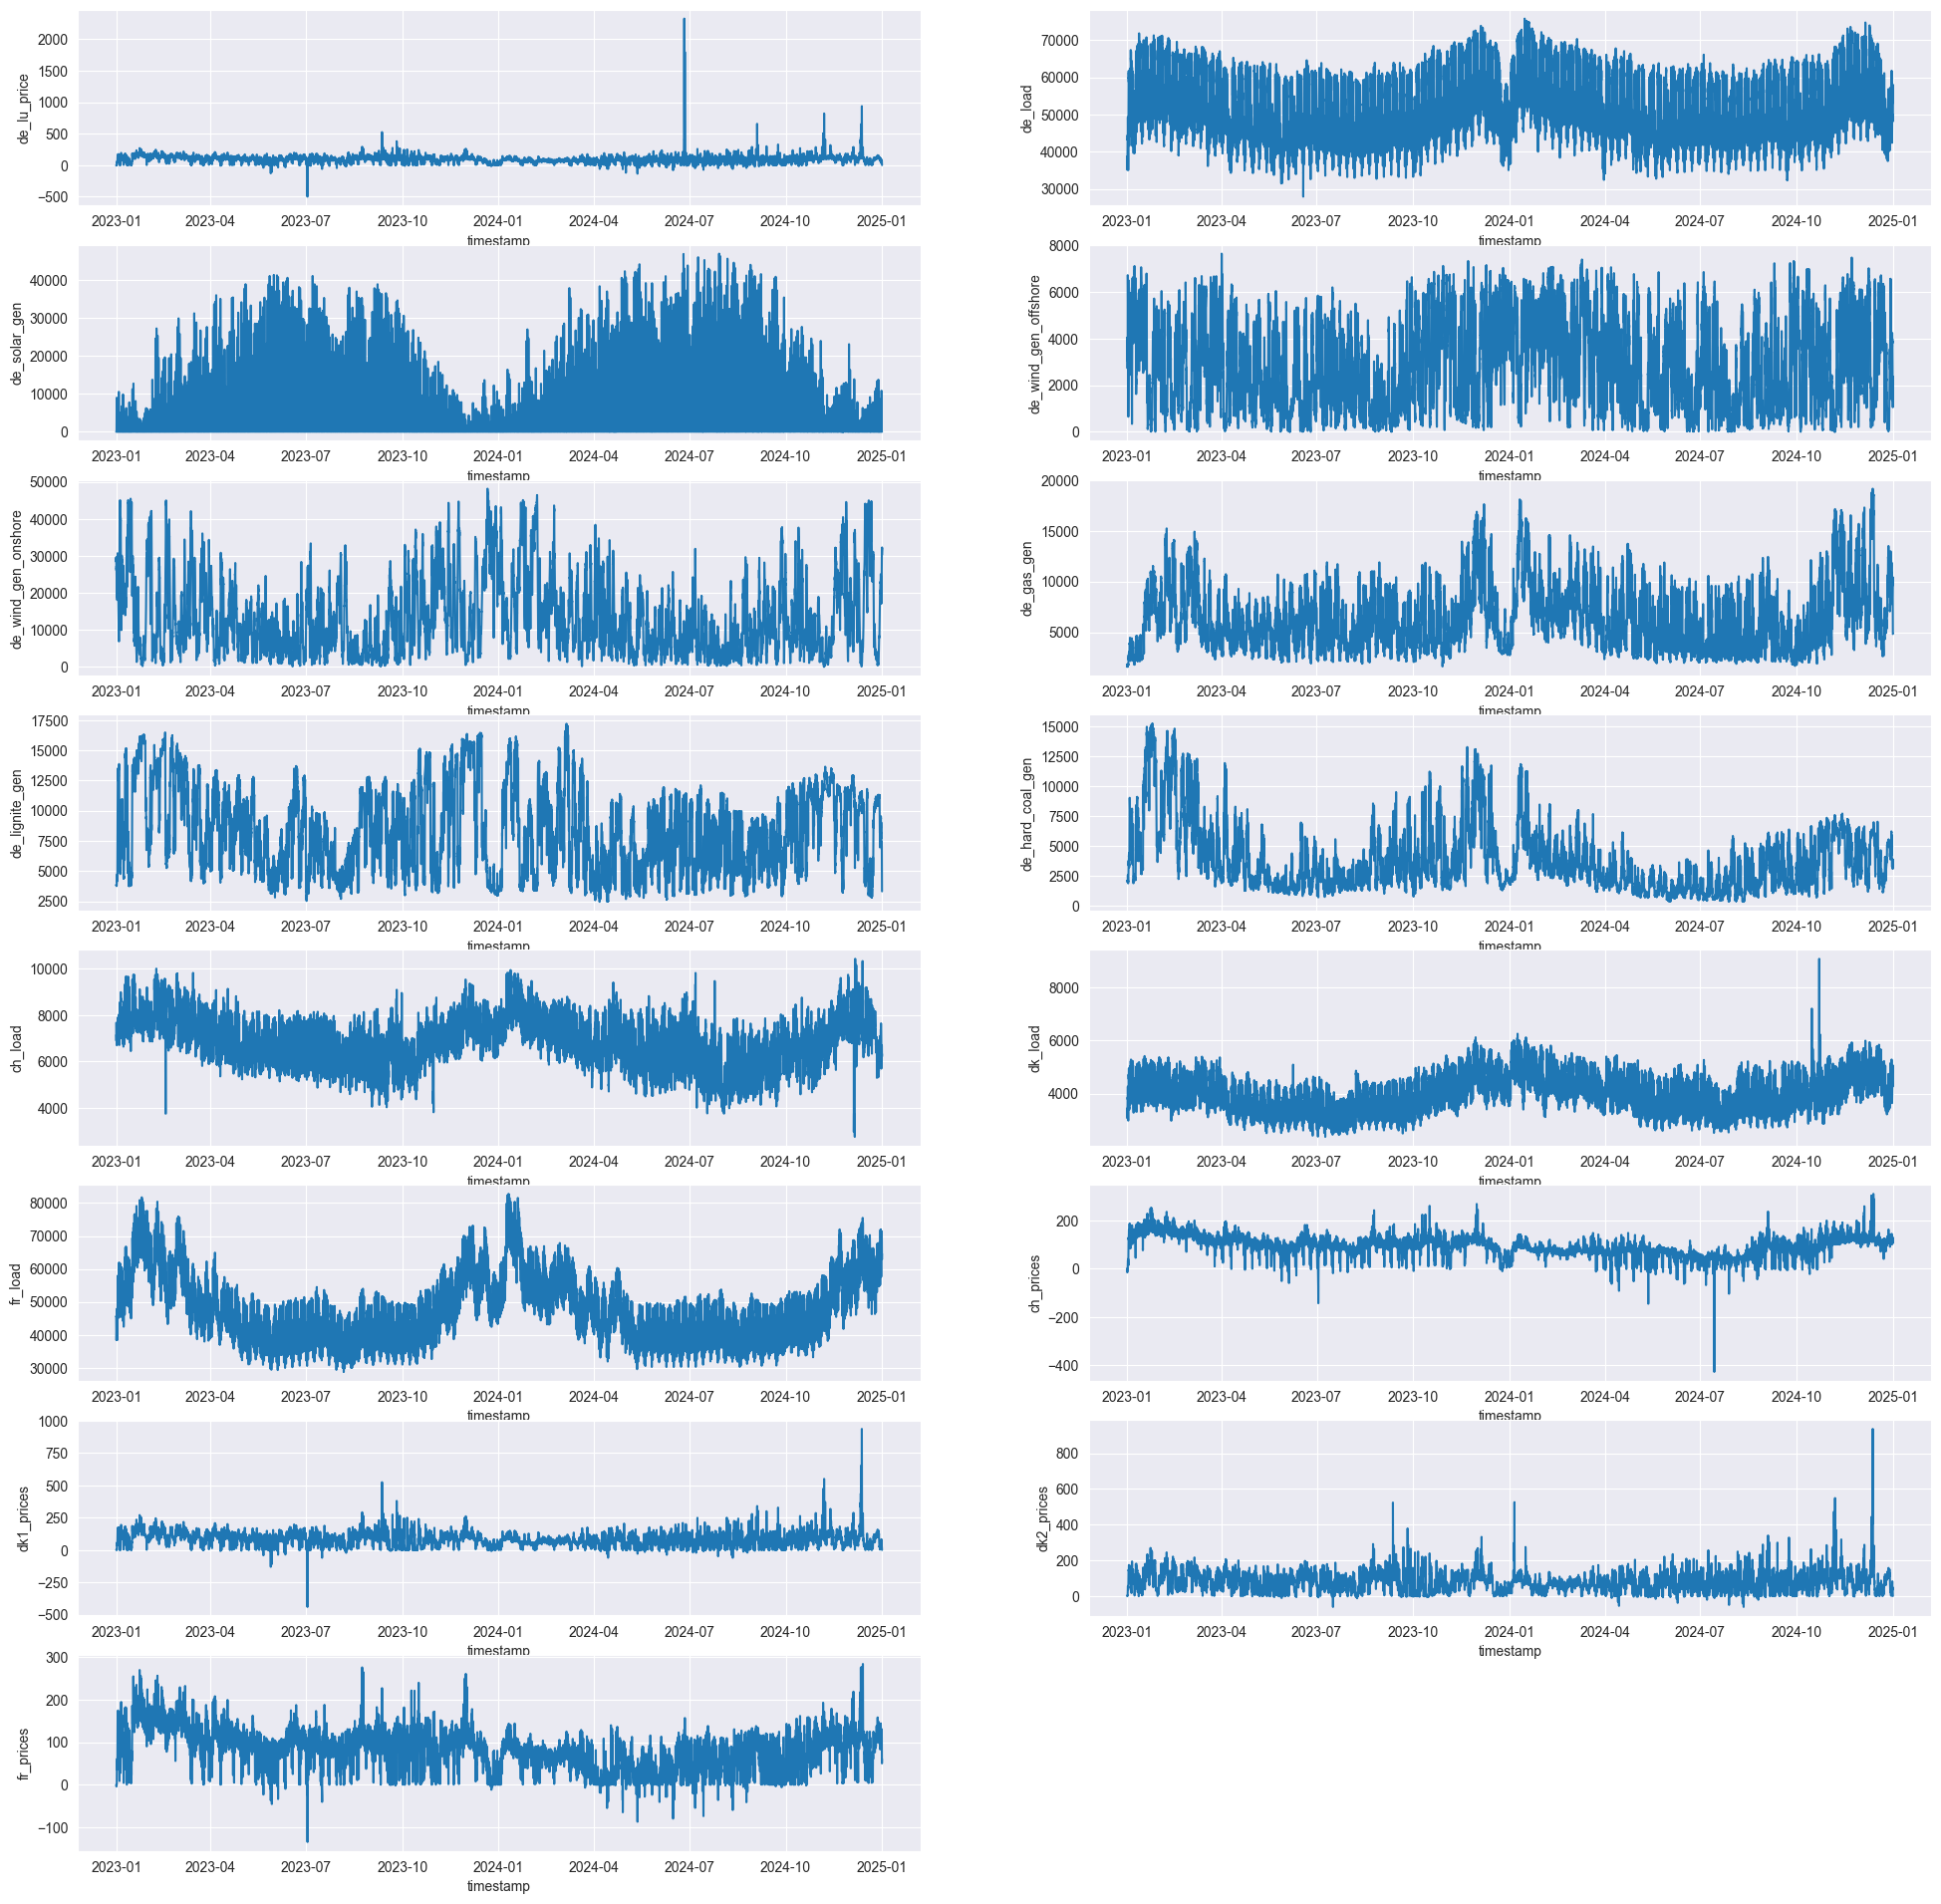

In [98]:
# plot all timeseries for visual inspection
plt.figure(figsize=(24, 24))

for _ in combined_df.columns:
    plt.subplot(8, 2, list(combined_df.columns).index(_)+1)
    sns.lineplot(data=combined_df[_])
    
plt.savefig('../reports/figures/raw_data_overview.png', dpi=300)

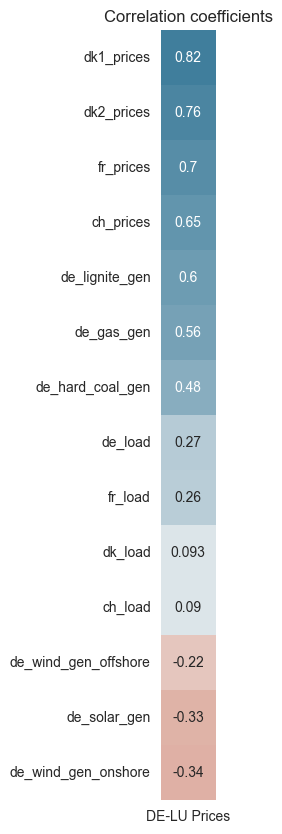

In [99]:
 # get pearson correlation coefficients and plot them
correlation_matrix = combined_df.corr(method='pearson')
correlation_matrix = correlation_matrix.drop(index=['de_lu_price'])
correlation_matrix = correlation_matrix[['de_lu_price']].sort_values(by='de_lu_price', ascending=False)

cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(8, 10))
sns.heatmap(correlation_matrix, 
            cmap=cmap,
            annot=True,  
            square=True, 
            cbar=False,
            center=0,
            xticklabels=['DE-LU Prices']).set_title('Correlation coefficients')

plt.savefig('../reports/figures/de_lu_price_correlations.png', dpi=300)

plt.show()

### fft and autocorrelation are not suitable because given timeseries is non-stationary

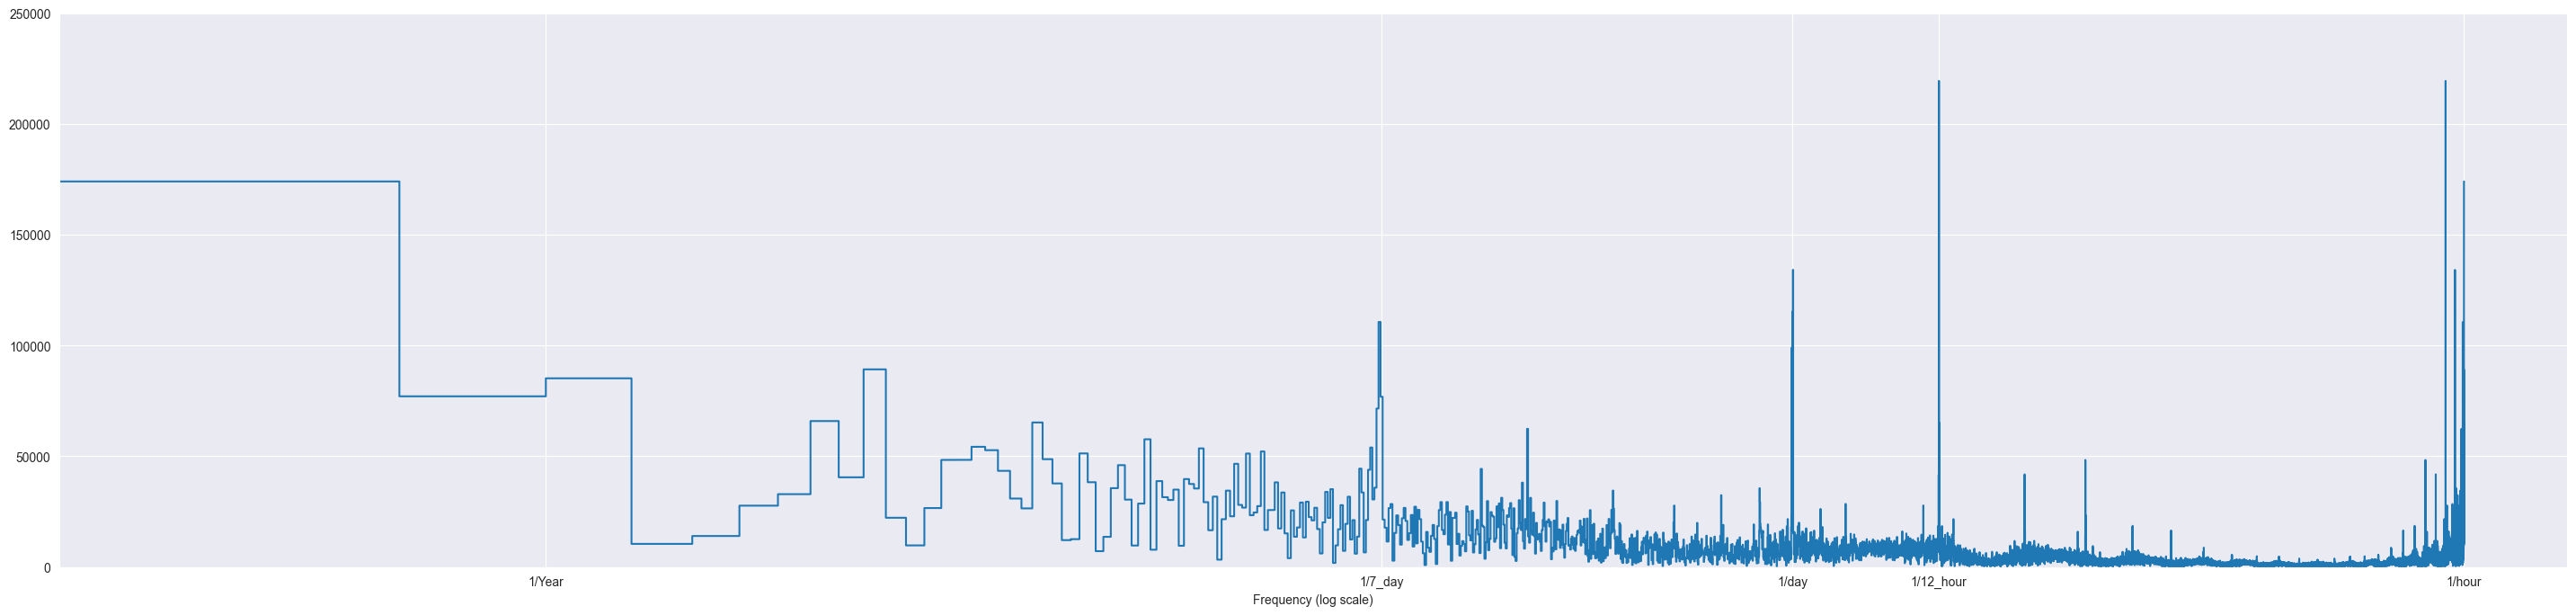

In [15]:
# to check which frequencies are present in the timeseries data fft is used
fft = tf.signal.fft(combined_df['de_lu_price'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(combined_df['de_lu_price'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / hours_per_year

plt.figure(figsize=(36, 8))
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 250000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/7, 365.2524, 365.2524*2, 365.2524*24], labels=['1/Year', '1/7_day', '1/day', '1/12_hour', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

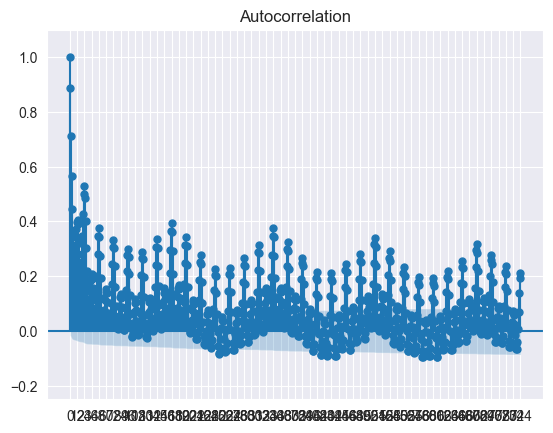

In [12]:
# to further validate time frequencies autocorrelation is measured
plot_acf(combined_df['de_lu_price'], lags=31*24)
plt.ylim(-0.25, 1.1)
plt.xticks(np.arange(0, 31*24+1, 12))
plt.show()

# Feature Engineering

In [115]:
combined_df = pd.read_csv('../data/interim/combined_data.csv', index_col=0, parse_dates=True)

### Detect and remove outliers

In [116]:
# remove outliers from features using Hampel Filter
def detect_and_remove_outliers(feature, window_length, n_sigma, impute_method: str = None) -> pd.DataFrame:
    """
    Detect and remove outliers from features using Hampel Filter. Only imputes where outliers are present.
    
    :param feature: The feature where outliers should be removed.
    :param window_length: Window length for Hampel Filter.
    :param n_sigma: Number of standard deviations for outlier detection.
    :param impute_method: Method for imputing missing values.
    
    :returns: DataFrame containing all features with outliers removed where applicable.
    """
    hampel = HampelFilter(window_length=window_length, n_sigma=n_sigma)
    imputer = Imputer(method=impute_method) if impute_method is not None else Imputer()
 
    feature_hat = hampel.fit_transform(feature)
    feature_imputed = imputer.fit_transform(feature_hat)
        
    return feature_imputed

In [117]:
# use nearest imputation for missing values to more or less preserve the shape of the timeseries
WINDOW_LENGTH = 24
N_SIGMA = 3
METHOD = 'nearest'

# detect and remove outliers in all price timeseries
for col in combined_df.columns:
    if 'price' in col:
        combined_df[col + '_hat'] = detect_and_remove_outliers(combined_df[col], WINDOW_LENGTH, N_SIGMA, METHOD)
        # drop touched cols
        combined_df.drop(columns=[col], inplace=True)

### Remove and store seasonal component

In [118]:
# remove seasonal component from all timeseries and store seasonal component to later add back to predictions
periods = [24, 7*24]
seasonal_component = {}

for col in combined_df.columns:
    mstl = MSTL(combined_df[col], periods=periods).fit()
    # remove seasonal component from timeseries by adding all seasonal components and then subtracting from original timeseries
    combined_df[col + '_rm_seasonal'] = combined_df[col] - sum(mstl.seasonal[f'seasonal_{p}'] for p in periods)
    seasonal_component.update({col + '_rm_seasonal': mstl})
    # drop touched cols
    combined_df.drop(columns=[col], inplace=True)

In [119]:
# save seasonal component to pickle
with open('../data/processed/seasonal_components.pkl', 'wb') as f:
    pkl.dump(seasonal_component, f, -1)

### Create Calendar Features

In [120]:
# create calendar features
combined_df['month'] = pd.DatetimeIndex(combined_df.index).month
# 1 = Monday, 7 = Sunday, add 1 because default is 0 = Monday
combined_df['day_of_week'] = pd.DatetimeIndex(combined_df.index).dayofweek + 1
# uses holiday library see references/refs.md [4]
de_holidays = holidays.country_holidays('DE', years=[2023,2024])
# set holiday to 1 if it is a holiday else 0
combined_df['holiday'] = combined_df.index.to_series().apply(lambda x: 1 if x in de_holidays else 0)

### Create Lags

In [121]:
# create lagged prices according to fft analysis based off of cleaned price data de_lu_price_hat
# 7 day, 1 day, 12 hour and 1 hour lags are introduced
combined_df['de_lu_price_7_day_lag'] = combined_df['de_lu_price_hat_rm_seasonal'].shift(7 * 24, fill_value=0)
combined_df['de_lu_price_1_day_lag'] = combined_df['de_lu_price_hat_rm_seasonal'].shift(24, fill_value=0)
combined_df['de_lu_price_12_hour_lag'] = combined_df['de_lu_price_hat_rm_seasonal'].shift(12, fill_value=0)
combined_df['de_lu_price_1_hour_lag'] = combined_df['de_lu_price_hat_rm_seasonal'].shift(1, fill_value=0)

In [123]:
# save engineered features to csv
combined_df_with_engineered_features = combined_df.copy()
combined_df_with_engineered_features.to_csv('../data/interim/combined_data_with_engineered_features.csv', index=True)

In [127]:
combined_df

,de_load_rm_seasonal,de_solar_gen_rm_seasonal,de_wind_gen_offshore_rm_seasonal,de_wind_gen_onshore_rm_seasonal,de_gas_gen_rm_seasonal,de_lignite_gen_rm_seasonal,de_hard_coal_gen_rm_seasonal,ch_load_rm_seasonal,dk_load_rm_seasonal,fr_load_rm_seasonal,...,dk1_prices_hat_rm_seasonal,dk2_prices_hat_rm_seasonal,fr_prices_hat_rm_seasonal,month,day_of_week,holiday,de_lu_price_7_day_lag,de_lu_price_1_day_lag,de_lu_price_12_hour_lag,de_lu_price_1_hour_lag
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00+00:00,49594.451017,1560.567219,3148.009145,25260.698843,2398.962574,7149.331330,4346.000552,7549.551807,3993.071539,49043.458318,...,69.625022,79.878606,64.683394,12,6,0,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:00:00+00:00,50014.050326,1547.539673,3591.873149,25306.120266,2430.104250,7080.911332,4415.371981,7549.788557,4002.537668,49756.201525,...,72.975606,82.494844,71.772860,1,7,1,0.000000,0.000000,0.000000,59.237365
2023-01-01 01:00:00+00:00,50142.277158,1535.775695,4010.209664,25304.884310,2416.035478,7078.608616,4498.871968,7567.771297,3996.803778,49827.785417,...,74.062323,84.075513,73.964489,1,7,1,0.000000,0.000000,0.000000,64.515174
2023-01-01 02:00:00+00:00,49946.634612,1523.803477,3972.811395,25285.956764,2382.670094,7129.434030,4540.044861,7153.239046,3937.575408,49771.334872,...,77.369882,86.659602,78.940550,1,7,1,0.000000,0.000000,0.000000,66.723422
2023-01-01 03:00:00+00:00,49486.383369,1513.976113,3918.557942,25102.525001,2411.335748,7221.594894,4580.350475,7324.665384,3885.856403,49505.882382,...,77.768006,88.779323,80.030259,1,7,1,0.000000,0.000000,0.000000,68.004958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 18:00:00+00:00,49817.303171,1950.192657,2299.244370,27693.633796,7539.317886,6166.039235,3420.089977,5795.232011,4425.842197,64112.335285,...,36.456318,32.853733,83.253990,12,2,0,99.397638,105.877055,77.787226,67.662825
2024-12-31 19:00:00+00:00,49814.889987,1950.508512,2104.382148,28256.435057,6988.208465,5909.408505,3460.616383,5800.650468,4456.518333,64412.976042,...,32.833589,32.752820,84.644232,12,2,0,92.968945,106.822289,73.513060,64.607452
2024-12-31 20:00:00+00:00,49803.040443,1953.608869,2212.570301,28690.310273,6880.665726,5128.262152,3484.750453,5892.878642,4470.212702,64676.398289,...,33.482019,33.426614,86.399321,12,2,0,87.001384,106.925838,74.697916,58.221412


### Create Feature set

In [124]:
# load combined_df with engineered features
processed_data = pd.read_csv('../data/interim/combined_data_with_engineered_features.csv', index_col=0, parse_dates=True)

In [128]:
# dict like structure to dynamically select features for model training from combined_df
features_dict = {
    # prices
    'de_lu_price_hat_rm_seasonal': {
        'select': 1,
        'name': 'DE-LU Prices',
        'is-numerical': True
    },
    'ch_prices_hat_rm_seasonal': {
        'select': 0,
        'name': 'CH Prices',
        'is-numerical': True
    },
    'dk1_prices_hat_rm_seasonal': {
        'select': 0,
        'name': 'DK1 Prices',
        'is-numerical': True
    },
    'dk2_prices_hat_rm_seasonal': {
        'select': 0,
        'name': 'DK2 Prices',
        'is-numerical': True
    },
    'fr_prices_hat_rm_seasonal': {
        'select': 0,
        'name': 'FR Prices',
        'is-numerical': True
    },
    # price lags
    'de_lu_price_7_day_lag': {
        'select': 0,
        'name': 'DE-LU Prices 7-Day Lag',
        'is-numerical': True
    },
    'de_lu_price_1_day_lag': {
        'select': 0,
        'name': 'DE-LU Prices 24-Hour Lag',
        'is-numerical': True
    },
    'de_lu_price_12_hour_lag': {
        'select': 0,
        'name': 'DE-LU Prices 12-Hour Lag',
        'is-numerical': True
    },
    'de_lu_price_1_hour_lag': {
        'select': 0,
        'name': 'DE-LU Prices 1-Hour Lag',
        'is-numerical': True
    },
    # generation
    'de_solar_gen_rm_seasonal': {
        'select': 1,
        'name': 'DE Solar Generation',
        'is-numerical': True
    },
    'de_wind_gen_offshore_rm_seasonal': {
        'select': 1,
        'name': 'DE Wind Generation Offshore',
        'is-numerical': True
    },
    'de_wind_gen_onshore_rm_seasonal': {
        'select': 1,
        'name': 'DE Wind Generation Onshore',
        'is-numerical': True
    },
    'de_gas_gen_rm_seasonal': {
        'select': 0,
        'name': 'DE Gas Generation',
        'is-numerical': True
    },
    'de_lignite_gen_rm_seasonal': {
        'select': 0,
        'name': 'DE Lignite Generation',
        'is-numerical': True
    },
    'de_hard_coal_gen_rm_seasonal': {
        'select': 0,
        'name': 'DE Hard Coal Generation',
        'is-numerical': True
    },
    # loads
    'de_load_rm_seasonal': {
        'select': 0,
        'name': 'DE Load',
        'is-numerical': True
    },
    'ch_load_rm_seasonal': {
        'select': 0,
        'name': 'CH Load',
        'is-numerical': True
    },
    'dk_load_rm_seasonal': {
        'select': 0,
        'name': 'DK Load',
        'is-numerical': True
    },
    'fr_load_rm_seasonal': {
        'select': 0,
        'name': 'FR Load',
        'is-numerical': True
    },
    # dummies
    'month': {
        'select': 1,
        'name': 'Month',
        'is-numerical': False
    },
    'day_of_week': {
        'select': 1,
        'name': 'Day of Week',
        'is-numerical': False
    },
    'holiday': {
        'select': 1,
        'name': 'Holiday',
        'is-numerical': False
    },
}

In [129]:
feature_set: pd.DataFrame = processed_data.loc[:, [k for k, v in features_dict.items() if v['select'] == 1]]

In [130]:
# save feature set to file
feature_set.to_csv('../data/interim/feature_set.csv', index=True)

# Model Prep

Note: largely following tutorial from [3] /references/refs.md with some additions

In [131]:
# load feature set from file
feature_set = pd.read_csv('../data/interim/feature_set.csv', index_col=0, parse_dates=True)
feature_set

,de_lu_price_hat_rm_seasonal,de_solar_gen_rm_seasonal,de_wind_gen_offshore_rm_seasonal,de_wind_gen_onshore_rm_seasonal,month,day_of_week,holiday
timestamp,,,,,,,
2022-12-31 23:00:00+00:00,59.237365,1560.567219,3148.009145,25260.698843,12,6,0
2023-01-01 00:00:00+00:00,64.515174,1547.539673,3591.873149,25306.120266,1,7,1
2023-01-01 01:00:00+00:00,66.723422,1535.775695,4010.209664,25304.884310,1,7,1
2023-01-01 02:00:00+00:00,68.004958,1523.803477,3972.811395,25285.956764,1,7,1
2023-01-01 03:00:00+00:00,69.209481,1513.976113,3918.557942,25102.525001,1,7,1
...,...,...,...,...,...,...,...
2024-12-31 18:00:00+00:00,64.607452,1950.192657,2299.244370,27693.633796,12,2,0
2024-12-31 19:00:00+00:00,58.221412,1950.508512,2104.382148,28256.435057,12,2,0
2024-12-31 20:00:00+00:00,56.674892,1953.608869,2212.570301,28690.310273,12,2,0


### Sliding Window Splitting

In [132]:
# train validation test splits 70, 20, 10
# use sliding window splits to prevent overfitting
column_indices = {name: i for i, name in enumerate(feature_set)}

sliding_window_length = 24*30*3 # three month windows
step_length = 24*7 # each window is shifted by one week
padding = 24 # padding of one day between sliding windows to ensure no data leakage

train_split = 0.7
validation_split = 0.2
test_split = 0.1

num_splits = int((len(feature_set) - sliding_window_length) / step_length)
num_features = feature_set.shape[1]

# create python lists with num_splits entries, each entry is a sliding window
train_df, validation_df, test_df = [], [], []
    
for i in range(num_splits):
    train_df.append(feature_set.iloc[i * step_length : i * step_length + int(sliding_window_length * train_split)])
    validation_df.append(feature_set.iloc[i * step_length + int(sliding_window_length * train_split) 
                                          : i * step_length + int(sliding_window_length * (train_split + validation_split))])
    test_df.append(feature_set.iloc[i * step_length + int(sliding_window_length * (train_split + validation_split))
                                    : i * step_length + int(sliding_window_length * (train_split + validation_split + test_split))])

### Normalization

In [158]:
train_df_hat, validation_df_hat, test_df_hat = [], [], []
train_mean, train_std = [], []

for i in range(num_splits):
    # only normalize the features that are numerical and not categorical, ie exclude month, day of week and holiday from normalization
    # Select numerical columns for normalization
    numerical_cols = [feature_set.columns[j] for j in range(len(feature_set.columns)) if features_dict[feature_set.columns[j]]['is-numerical']]
    categorical_cols = [col for col in feature_set.columns if col not in numerical_cols]

    # Normalize numerical columns
    train_mean.append(train_df[i][numerical_cols].mean())
    train_std.append(train_df[i][numerical_cols].std())

    train_df_hat.append((train_df[i][numerical_cols] - train_mean[i]) / train_std[i])
    validation_df_hat.append((validation_df[i][numerical_cols] - train_mean[i]) / train_std[i])
    test_df_hat.append((test_df[i][numerical_cols] - train_mean[i]) / train_std[i])

    # Rejoin categorical columns
    train_df_hat[i] = train_df_hat[i].join(train_df[i][categorical_cols])
    validation_df_hat[i] = validation_df_hat[i].join(validation_df[i][categorical_cols])
    test_df_hat[i] = test_df_hat[i].join(test_df[i][categorical_cols])

C:\Users\valen\AppData\Local\Temp\ipykernel_16048\3484263534.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels([features_dict[name].get('name') for name in keys])
C:\Users\valen\AppData\Local\Temp\ipykernel_16048\3484263534.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels([features_dict[name].get('name') for name in keys])
C:\Users\valen\AppData\Local\Temp\ipykernel_16048\3484263534.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels([features_dict[name].get('name') for name in keys])
C:\Users\valen\AppData\Local\Temp\ipykernel_16048\3484263534.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

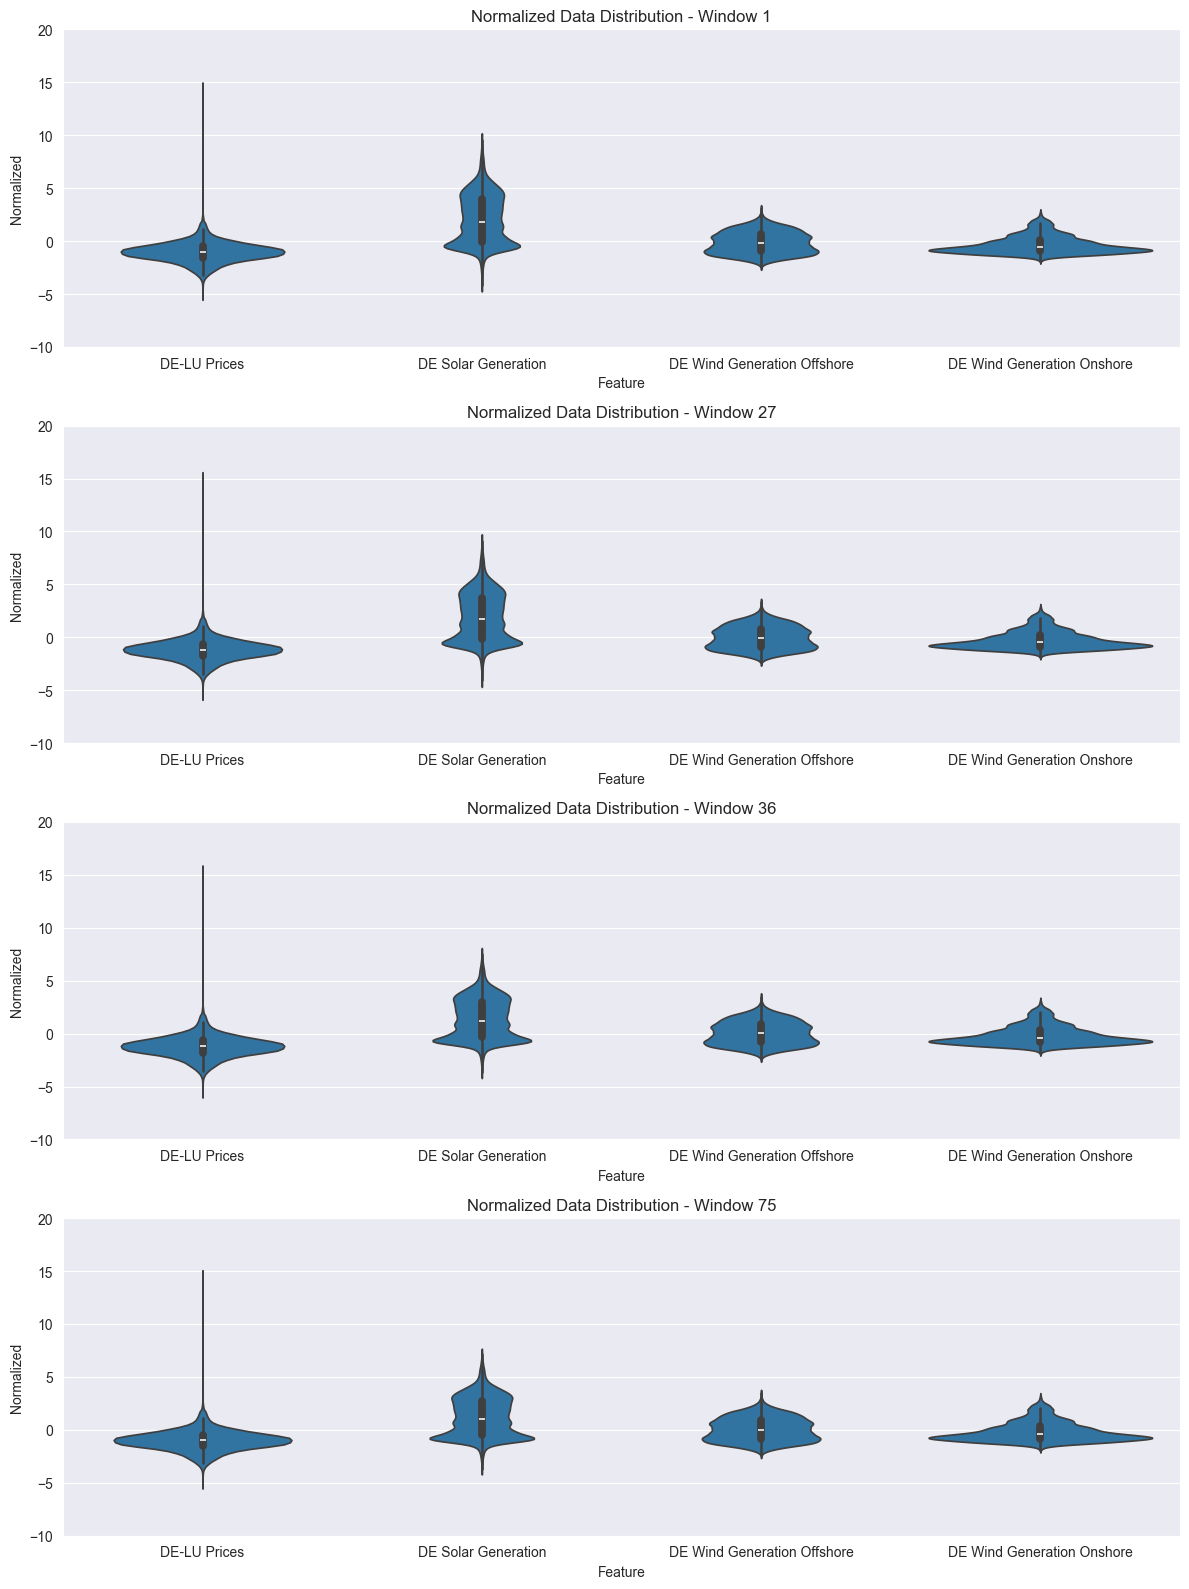

<Figure size 640x480 with 0 Axes>

In [140]:
# exemplary plot for normalized data of 4 random sliding windows
feature_set_norm_plot = feature_set.drop(columns=['day_of_week', 'month', 'holiday'])
keys = feature_set_norm_plot.keys()

random_indices = [1, 27, 36, 75]
plt.figure(figsize=(12, 16))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 1, i + 1)
    df_std = (feature_set_norm_plot - train_mean[i]) / train_std[i]
    df_std = df_std.melt(var_name='Feature', value_name='Normalized')
    ax = sns.violinplot(x='Feature', y='Normalized', data=df_std)
    plt.title(f'Normalized Data Distribution - Window {idx}')
    plt.ylim(-10, 20)
    _ = ax.set_xticklabels([features_dict[name].get('name') for name in keys])
    
plt.tight_layout()
plt.show()

plt.savefig('../reports/figures/normalized_data_distribution_first_window.png', dpi=300)

In [141]:
# save train, val and test sets to csv
# use highest protocol available, denoted by -1
with open('../data/processed/train_df.pkl', 'wb') as f:
    pkl.dump(train_df_hat, f, -1)
    
with open('../data/processed/validation_df.pkl', 'wb') as f:
    pkl.dump(validation_df_hat, f, -1)
    
with open('../data/processed/test_df.pkl', 'wb') as f:
    pkl.dump(test_df_hat, f, -1)

### Window generation for training

In [179]:
# code taken from [3] /references/refs.md
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df_list=train_df_hat, validation_df_list=validation_df_hat, test_df_list=test_df_hat, 
                 label_columns=None):
        # Store the raw data.
        self.train_df_list = train_df_list
        self.validation_df_list = validation_df_list
        self.test_df_list = test_df_list

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df_list[0].columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
    
      return inputs, labels
    
    def make_dataset(self, data_list):
      data_list = np.array(data_list, dtype=np.float32)
              
      ds = keras.utils.timeseries_dataset_from_array(
          data=data_list,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,
      )
        
      ds = ds.map(self.split_window)
      
      return ds
    
    @property
    def train(self):
      return self.make_dataset(self.train_df_list)

    @property
    def val(self):
      return self.make_dataset(self.validation_df_list)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df_list)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
          # No example batch was found, so get one from the `.train` dataset
          result = next(iter(self.train))
          # And cache it for next time
          self._example = result
        return result
    
    def plot(self, model=None, plot_col='de_lu_price_hat_rm_seasonal', max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
    
        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index
    
        if label_col_index is None:
          continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
        if n == 0:
          plt.legend()
    
      plt.xlabel('Time [h]')


# Multi-Step-Ahead, Single Shot Models

In [182]:
# load datasets
with open('../data/processed/train_df.pkl', 'rb') as f:
    train_df_hat = pkl.load(f)
    
with open('../data/processed/validation_df.pkl', 'rb') as f:
    validation_df_hat = pkl.load(f)
    
with open('../data/processed/test_df.pkl', 'rb') as f:
    test_df_hat = pkl.load(f)

In [186]:
# global params
MAX_EPOCHS = 20
OUT_STEPS = 24

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=2,
                                               mode='min')

window = WindowGenerator(input_width=24, 
                         label_width=OUT_STEPS,
                         shift=OUT_STEPS,
                         label_columns=['de_lu_price_hat_rm_seasonal'],)

val_performance = {}
performance = {}

window.split_window

<bound method WindowGenerator.split_window of Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['de_lu_price_hat_rm_seasonal']>

### Baseline

In [194]:
data = np.array(train_df_hat[0], dtype=np.float32)

ds = keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=48,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,
      )
        
ds = ds.map(window.split_window)

ds.

AttributeError: '_MapDataset' object has no attribute 'np'

In [117]:
class RepeatBaseline(keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=keras.losses.MeanSquaredError(),
                        metrics=[keras.metrics.MeanAbsoluteError()])

IPython.display.clear_output()

val_performance['Repeat'] = repeat_baseline.evaluate(window.val, return_dict=True)
performance['Repeat'] = repeat_baseline.evaluate(window.test, verbose=0, return_dict=True)

window.plot(repeat_baseline)

ValueError: Unrecognized data type: x=(<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>) (of type <class 'tuple'>)

### LSTM

In [118]:
def lstm_builder(hp):
    model = keras.Sequential()
      
    # Tune the number of lstm layers choose from 32 up to 512 with steps of 32
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
      
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
      
    # build model
    model.add(keras.layers.LSTM(hp_units, return_sequences=False))
    model.add(keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()))
    model.add(keras.layers.Reshape([OUT_STEPS, num_features]))
    
    # compile the model
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [119]:
lstm_tuner = (kt.BayesianOptimization
(
    lstm_builder,
    objective='mean_absolute_error',
    max_trials=10,
    directory='../models/tuner',
))

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

lstm_tuner.search(
    window.train,
    epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 2 Complete [00h 00m 00s]

Best mean_absolute_error So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
384               |480               |units
0.001             |0.001             |learning_rate



Traceback (most recent call last):
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*a

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py", line 51, in unpack_x_y_sample_weight
    raise ValueError(error_msg)
ValueError: Data is expected to be in format `x`, `(x,)`, `(x, y)`, or `(x, y, sample_weight)`, found: (<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>)


In [38]:
history_lstm = best_lstm_model.fit(window.train, epochs=MAX_EPOCHS,
                                   validation_data=window.val,
                                   callbacks=[early_stopping])

IPython.display.clear_output()

val_performance['LSTM'] = best_lstm_model.evaluate(window.val, return_dict=True)
performance['LSTM'] = best_lstm_model.evaluate(window.test, verbose=0, return_dict=True)

best_lstm_model.save('../models/lstm_vre_only.keras')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7296.7544 - mean_absolute_error: 76.3806


### GRU

In [142]:
def gru_builder(hp):
    model = keras.Sequential()
    
    # Tune the number of lstm layers choose from 32 up to 512 with steps of 32
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
      
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # build model
    model.add(keras.layers.LSTM(hp_units, return_sequences=False))
    model.add(keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()))
    model.add(keras.layers.Reshape([OUT_STEPS, num_features]))

    # compile the model
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [ ]:
gru_tuner = (kt.BayesianOptimization
(
    gru_builder,
    objective='mean_absolute_error',
    max_trials=10,
    directory='../models/tuner',
    overwrite=True,
))

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

gru_tuner.search(
    window.train,
    epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = gru_tuner.get_best_hyperparameters(num_trials=1)[0]
best_gru_model = gru_tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [143]:
history_gru = best_gru_model.fit(window.train, epochs=MAX_EPOCHS,
                                 validation_data=window.val,
                                 callbacks=[early_stopping])

IPython.display.clear_output()

val_performance['GRU'] = best_gru_model.evaluate(window.val, return_dict=True)
performance['GRU'] = best_gru_model.evaluate(window.test, verbose=0, return_dict=True)

best_gru_model.save('../models/gru_vre_only.keras')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7516.4951 - mean_absolute_error: 77.5791


### CNN

In [163]:
def conv_builder(hp):
    model = keras.Sequential()
    
    # Tune the number of lstm layers choose from 32 up to 512 with steps of 32
    hp_units = hp.Int('units', min_value=32, max_value=2048, step=32)
      
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # tune the kernel size for the convolutional layer choose from 1 to 10
    hp_kernel_size = hp.Int('kernel_size', min_value=1, max_value=10, step=1)
    
    # build model
    model.add(keras.layers.Lambda(lambda x: x[:, -hp_kernel_size:, :]))
    model.add(keras.layers.Conv1D(hp_units, activation='relu', kernel_size=hp_kernel_size))
    model.add(keras.layers.Dense(OUT_STEPS*num_features,
                                 kernel_initializer=tf.initializers.zeros()))
    model.add(keras.layers.Reshape([OUT_STEPS, num_features]))
    
    # compile the model
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [ ]:
conv_tuner = (kt.BayesianOptimization
(
    conv_builder,
    objective='mean_absolute_error',
    max_trials=10,
    directory='../models/tuner',
    overwrite=True,
))

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

conv_tuner.search(
    window.train,
    epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = conv_tuner.get_best_hyperparameters(num_trials=1)[0]
best_conv_model = conv_tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [164]:
history_conv = best_conv_model.fit(window.train, epochs=MAX_EPOCHS,
                                   validation_data=window.val,
                                   callbacks=[early_stopping])

IPython.display.clear_output()

val_performance['Conv'] = best_conv_model.evaluate(window.val, return_dict=True)
performance['Conv'] = best_conv_model.evaluate(window.test, verbose=0, return_dict=True)

best_conv_model.save('../models/conv_vre_only.keras')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31443584.0000 - mean_absolute_error: 3609.1191


## Model Evaluation

In [39]:
performance

{'Repeat': {'loss': 3.669363021850586,
  'mean_absolute_error': 1.2923485040664673},
 'LSTM': {'loss': 1.650113582611084,
  'mean_absolute_error': 0.6910204291343689}}

[3260.193115234375, 76.7915267944336]
[1.2923485040664673, 0.6910204291343689]


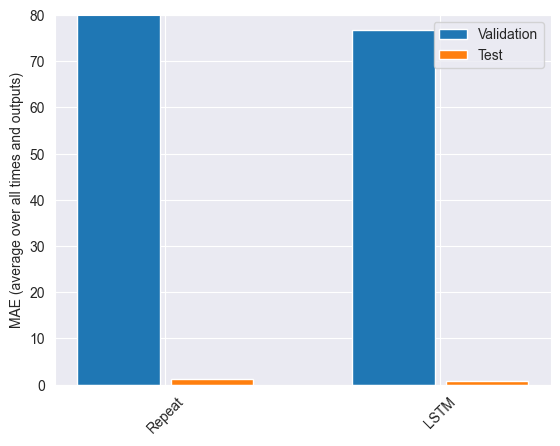

In [47]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

print(val_mae)
print(test_mae)

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


In [48]:
for name, value in performance.items():
  print(f'{name:7s}: {value[metric_name]:0.4f}')

Repeat : 1.2923
LSTM   : 0.6910


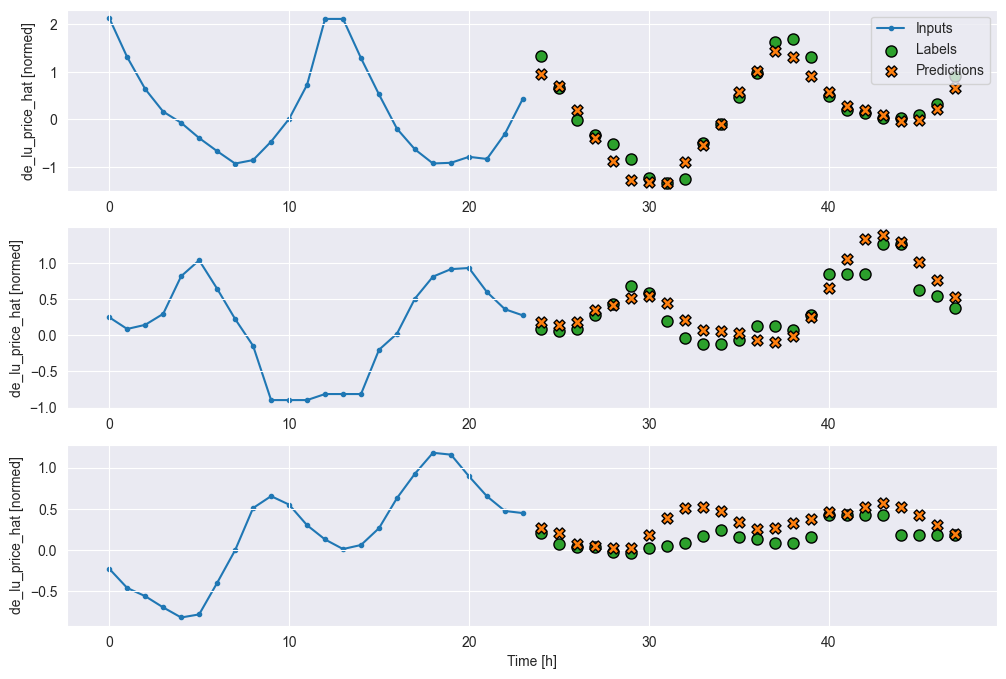

In [49]:
window.plot(best_lstm_model, 'de_lu_price_hat')

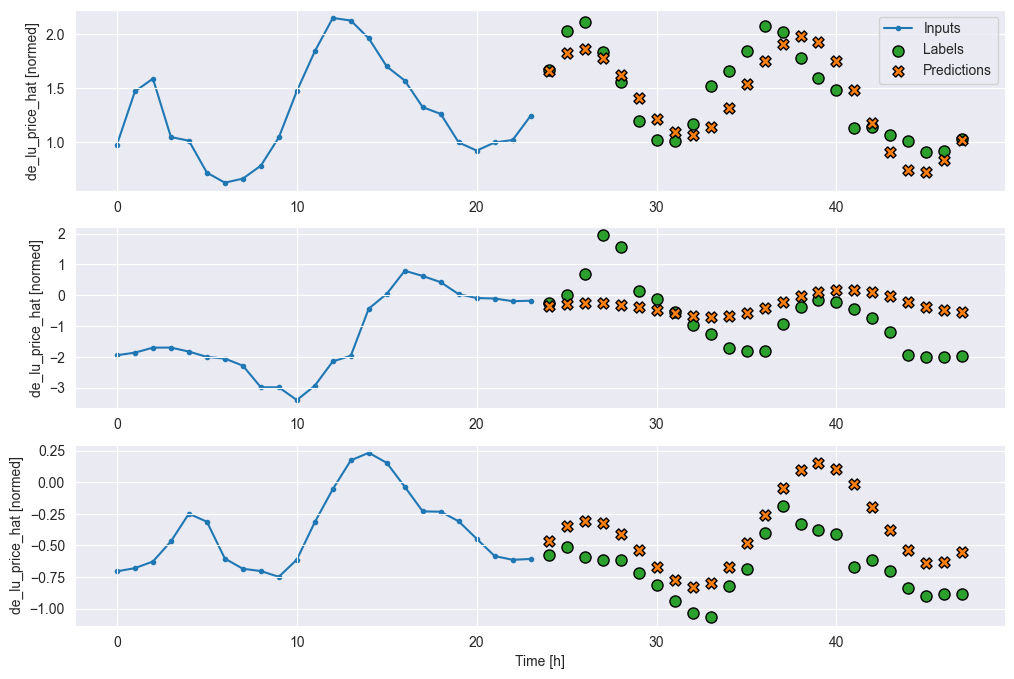

In [106]:
window.plot(best_gru_model, 'de_lu_price_hat')

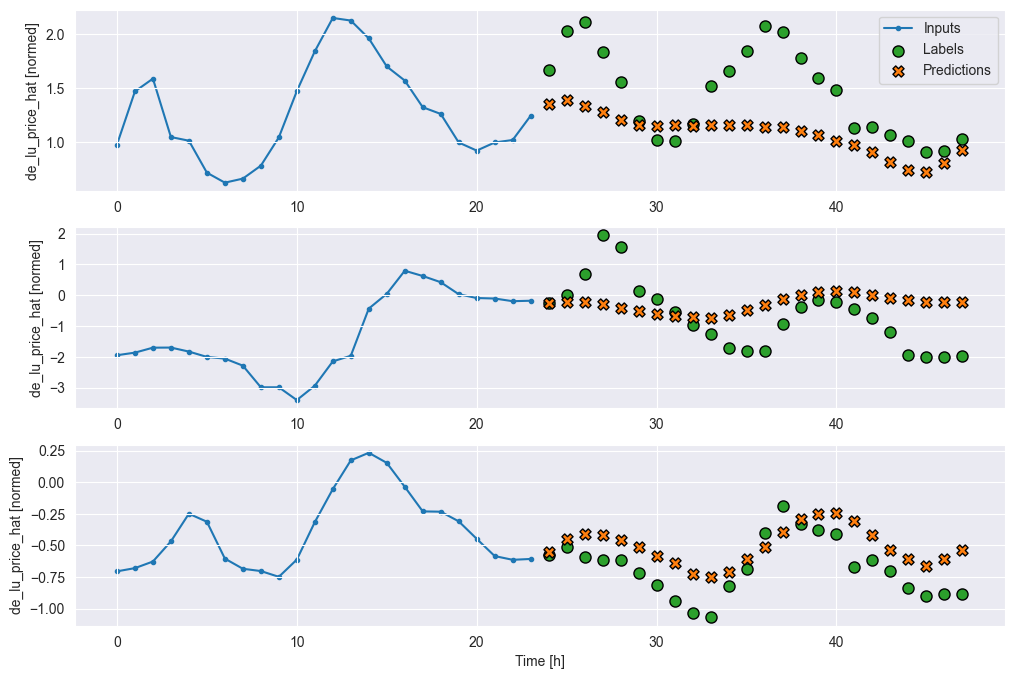

In [107]:
window.plot(best_conv_model, 'de_lu_price_hat')

# continue here https://www.tensorflow.org/tutorials/keras/keras_tuner